In [9]:
## This file is part of Jax Geometry
#
# Copyright (C) 2021, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/jaxgeometry
#
# Jax Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Jax Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Jax Geometry. If not, see <http://www.gnu.org/licenses/>.
#

In [10]:
#Modules

#JAX
import jax.numpy as jnp
from jax import lax

#Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

#JAXGeometry
from src.manifolds.Euclidean import *
from src.plotting import *
from IPython.display import clear_output
from src.Riemannian import metric, geodesic
from src.stochastics import Brownian_coords
from src.stochastics import product_sde
from src.stochastics.product_sde import tile

#Neural Networks
import haiku as hk
import optax
import jaxopt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

#Own modules
import score_matching as sm

#%matplotlib notebook

# 3d Euclidean Geometry

In [11]:
#Defining manifold
M = Euclidean(N=3)
print(M)

Euclidean manifold of dimension 3


In [12]:
#Hyper parameters
x0 = M.coords([0.,0.,0.])
max_T = 1.0
T = 0.5

metric.initialize(M)
geodesic.initialize(M)
Brownian_coords.initialize(M)

In [13]:
(product,sde_product,chart_update_product) = product_sde.initialize(M,M.sde_Brownian_coords,
                                                                    M.chart_update_Brownian_coords)

In [14]:
def get_coords(Fx):
    chart = M.centered_chart(Fx)
    return (Fx, chart)

## Simulate Synthetic Data

### Simulating Circle on Sphere

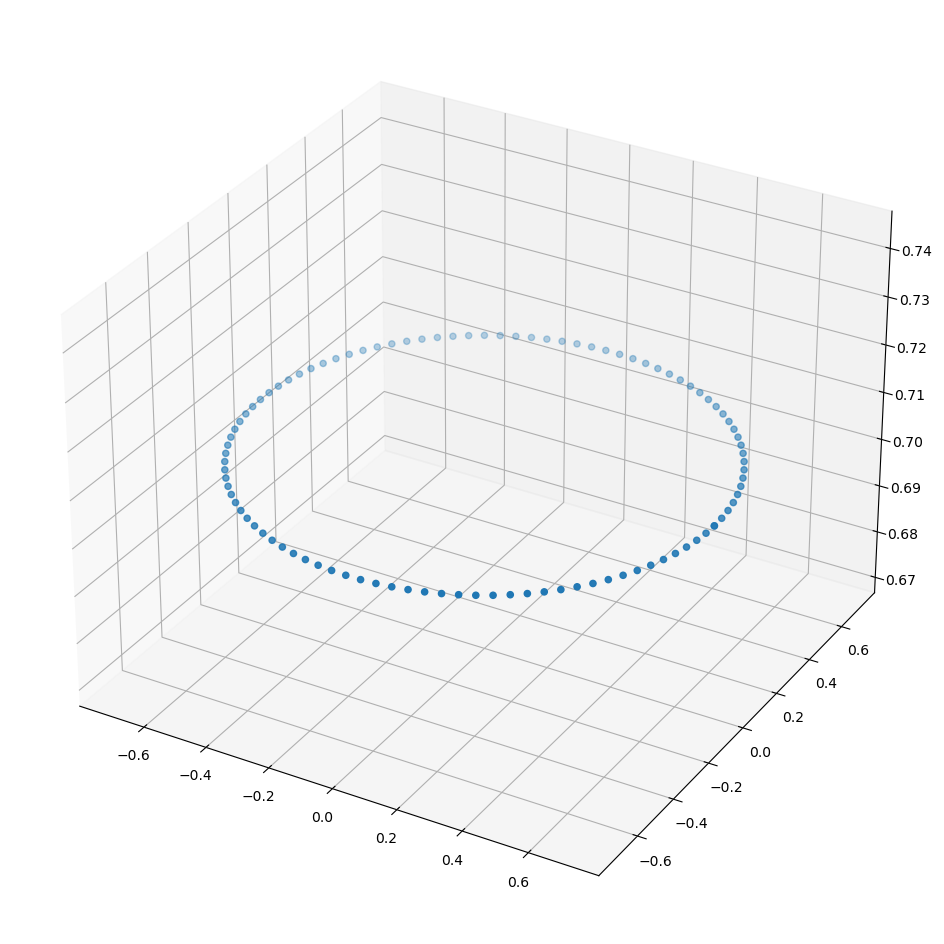

In [15]:
# Creating the theta and phi values.
N_points = 100
theta = jnp.pi/4
phi = jnp.linspace(0.0, jnp.pi*2, N_points)
X1_circle = jnp.sin(theta)*jnp.cos(phi)
X2_circle = jnp.sin(theta)*jnp.sin(phi)
X3_circle = jnp.cos(theta)*jnp.ones(N_points)
X_circle = jnp.concatenate((X1_circle.reshape(1,-1), X2_circle.reshape(1,-1), X3_circle.reshape(1,-1))).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_circle, X2_circle, X3_circle)
plt.show()

### Simulating Brownian Motion on Sphere

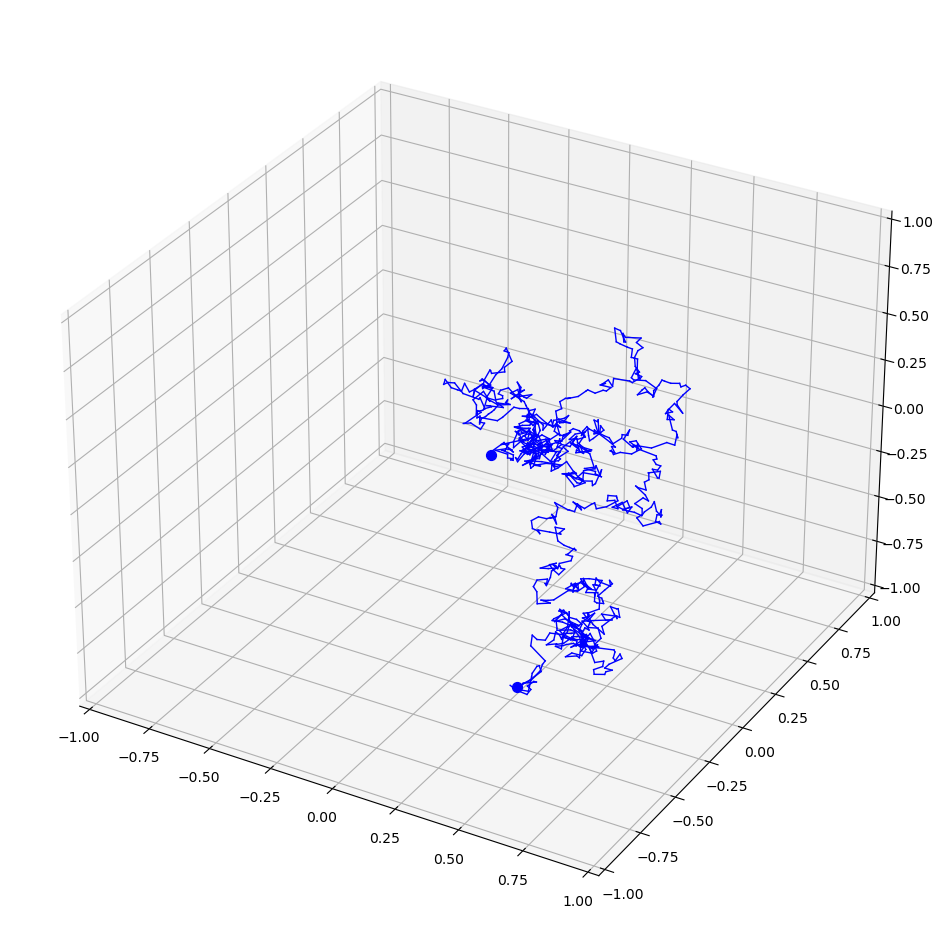

In [16]:
_dts = dts(T = T, n_steps=1000)
(ts,xs,charts) = M.Brownian_coords(x0,_dts,dWs(M.dim,_dts))

X_bm = (xs, charts)

# plot
newfig()
M.plot()
M.plot_path(zip(xs,charts))
plt.show()

## Theoretical Heat Kernel in Euclidean Space

The heat kernel in $\mathbb{R}^{m}$ is given by

\begin{equation}
    p(x,y,t) = \frac{1}{(2\pi t)^{m/2}}e^{-\frac{-||x-y||^{2}}{2t}},
\end{equation}

which implies that

\begin{equation}
    \log p(x,y,t) = -\frac{||x-y||^{2}}{2t}-\frac{m}{2}\log\left(2\pi t\right)
\end{equation}

Thus

\begin{equation}
    \nabla_{x} \log p(x,y,t) = \frac{y-x}{t}
\end{equation}

In [39]:
def p_sm(x,y,t, m=3):
    
    const = (2*jnp.pi*t)**(m/2)
    
    return jnp.exp(-jnp.sum((x-y)**2)/(2*t))/const
    
def grad_log_p_sm(x,y,t):
    
    return -(y-x)/t

The following plot displays the heat kernel on the sphere

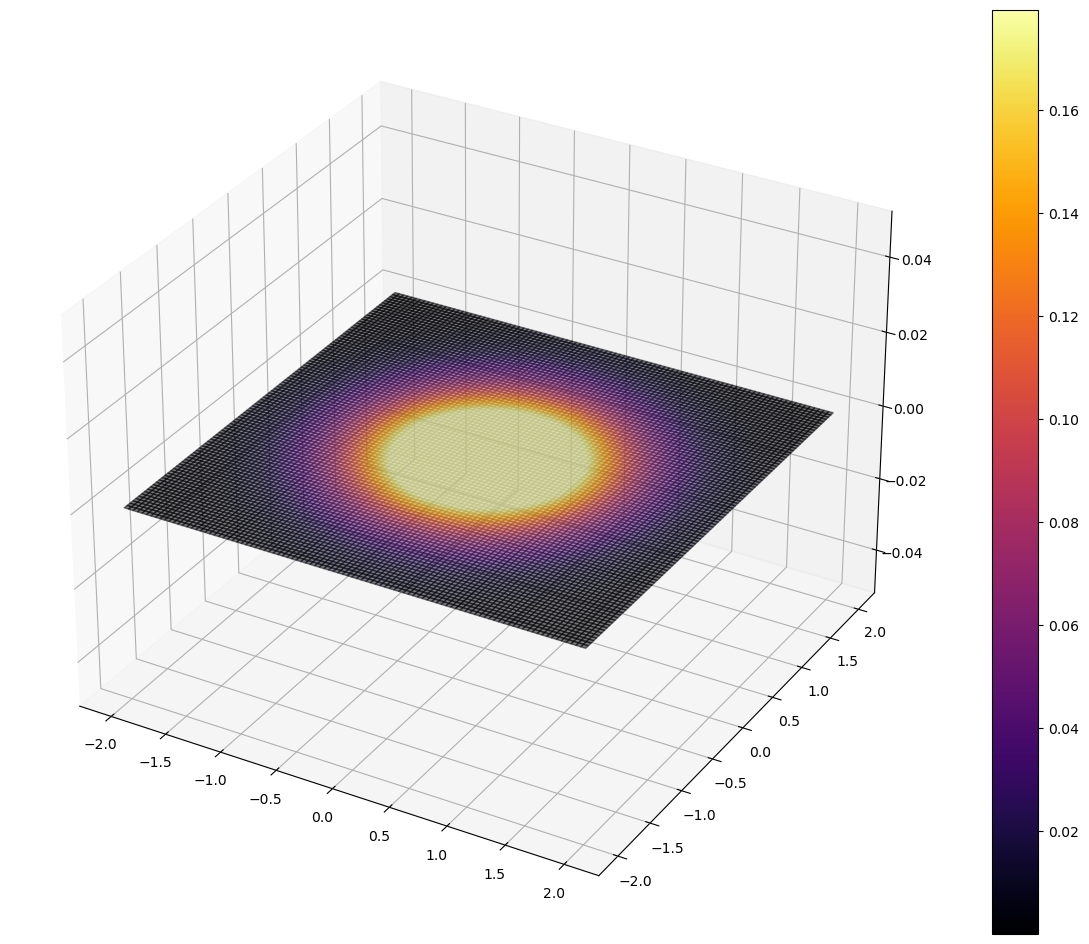

In [40]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

# Creating the theta and phi values.
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1, X2 = jnp.meshgrid(x1, x2)
X3 = jnp.zeros_like(X1)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, intervals, intervals), 
                     X2.reshape(1, intervals, intervals), 
                     X3.reshape(1, intervals, intervals))), axes=(1,2,0))

heat_map = vmap(lambda x2: vmap(lambda x1: p_sm(x0[-1], x1, T))(x2))(X)

# Creating the plot.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
plt.colorbar(m)

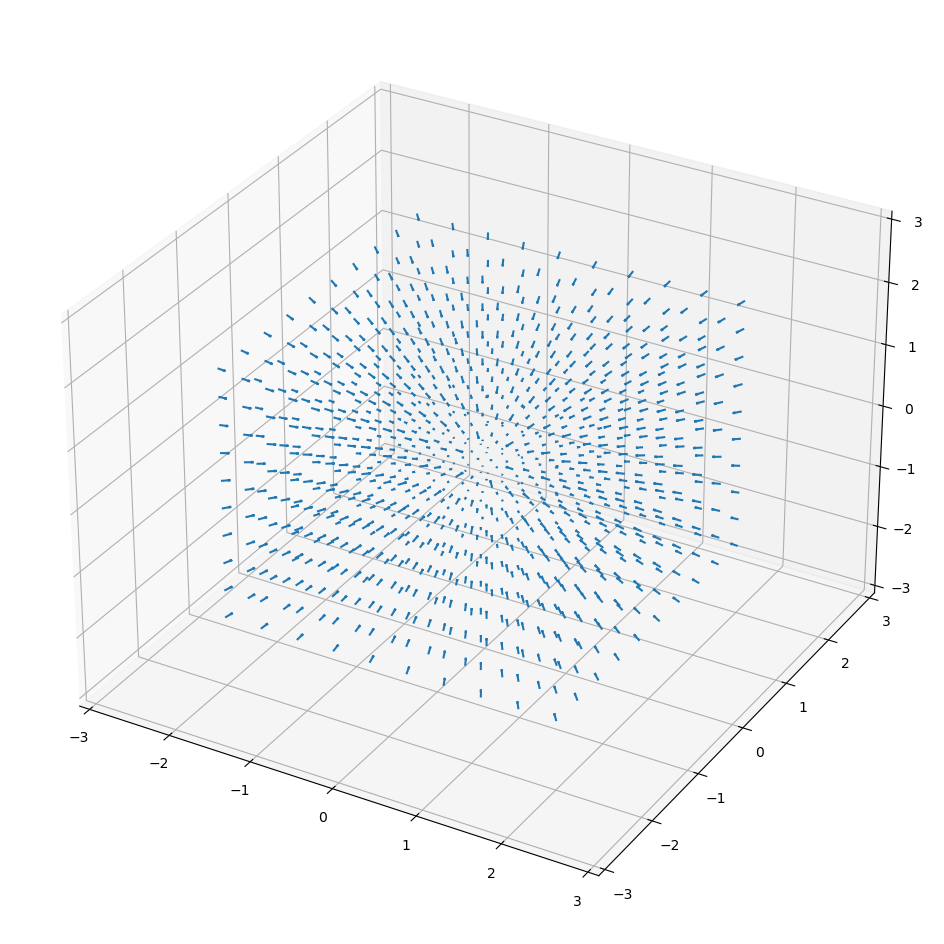

In [41]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: grad_log_p_sm(x0[0], x3, T))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

## Diffusion Mean

In [42]:
#%% Modules

import jax.numpy as jnp
from jax import vmap, jit, lax

#%% Code

def diffusion_mean(M, X_obs, gradlog_hk_fun, T = 1.0, eta = 0.1,
                   mu_init=None, _iter = 100):
    
    def gradient_descent_step(mu, dummy):
        
        mu = M.Exp(mu, -eta*grad_error(mu))
        
        return mu, None
    
    if mu_init is None:
        mu_init = get_coords(X_obs[0])
        
    grad_error = jit(lambda mu: -jnp.sum(vmap(lambda y: gradlog_hk_fun(mu[1], y, T))(X_obs), axis=0))
    
    yT, _ = lax.scan(gradient_descent_step, mu_init, xs=jnp.arange(0, _iter, 1))
   
    return yT

In [43]:
test = diffusion_mean(M, X_circle, grad_log_p_sm, T=T, eta = 0.0000001, mu_init = None, _iter=10000)

print(test)
print(x0)


(Array([ 7.0710677e-01, -1.8946444e-09,  5.8789748e-01], dtype=float32), Array([0.], dtype=float32))
(Array([0., 0., 0.], dtype=float32), Array([0.], dtype=float32))


## Learning $\nabla_{x}\log p$ using theoretical gradient

Some text here

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$ and $T$

In [44]:
#Hyper parameters
learning_rate = 0.001
epochs = 100
batch_size = 2**5
samples_size = batch_size*2**4
maxiter = epochs * samples_size // batch_size

In [45]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""

        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x3 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)

        yield jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))).T


In [46]:
#Brownian generator
_dts = dts(T=T)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        (ts,xss,chartss,*_) = product(tile(x0,N),
                                      _dts,
                                      dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]

        yield samples

In [62]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(40), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(10), jax.nn.tanh,
        hk.Linear(3),
    ])
#     y = jax.vmap(to_TM)(x.reshape([-1,M.emb_dim]),model(x.reshape([-1,M.emb_dim]))).reshape(x.shape)
    y = model(x)
    return y

In [63]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    true_s = vmap(lambda x1: grad_log_p_sm(x0[-1], x1, T))(data)

    return jnp.linalg.norm(s-true_s)**2

In [64]:
#Data loader
#generator = generator_unif #Generate uniformly distirbuted numbers
generator = generator_bm #Generate from Browninan motion in x0
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,3]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate) #Adam Optimizer
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 113.115.
[Step 20], epoch 1, training loss: 103.668.
[Step 30], epoch 1, training loss: 84.847.
[Step 40], epoch 2, training loss: 61.744.
[Step 50], epoch 3, training loss: 41.725.
[Step 60], epoch 3, training loss: 45.646.
[Step 70], epoch 4, training loss: 35.306.
[Step 80], epoch 5, training loss: 39.223.
[Step 90], epoch 5, training loss: 30.326.
[Step 100], epoch 6, training loss: 34.673.
[Step 110], epoch 6, training loss: 12.270.
[Step 120], epoch 7, training loss: 29.879.
[Step 130], epoch 8, training loss: 30.069.
[Step 140], epoch 8, training loss: 16.192.
[Step 150], epoch 9, training loss: 18.143.
[Step 160], epoch 10, training loss: 21.783.
[Step 170], epoch 10, training loss: 17.845.
[Step 180], epoch 11, training loss: 22.561.
[Step 190], epoch 11, training loss: 12.421.
[Step 200], epoch 12, training loss: 21.623.
[Step 210], epoch 13, training loss: 21.077.
[Step 220], epoch 13, training loss: 1

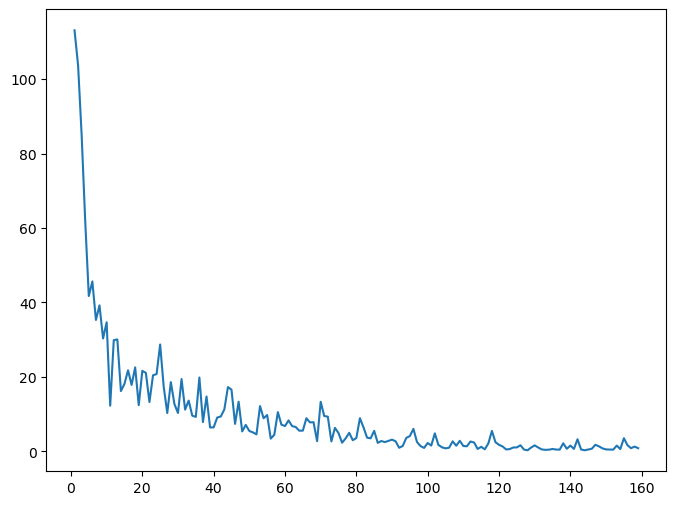

In [65]:
plt.figure(figsize=(8,6))
plt.plot(loss)

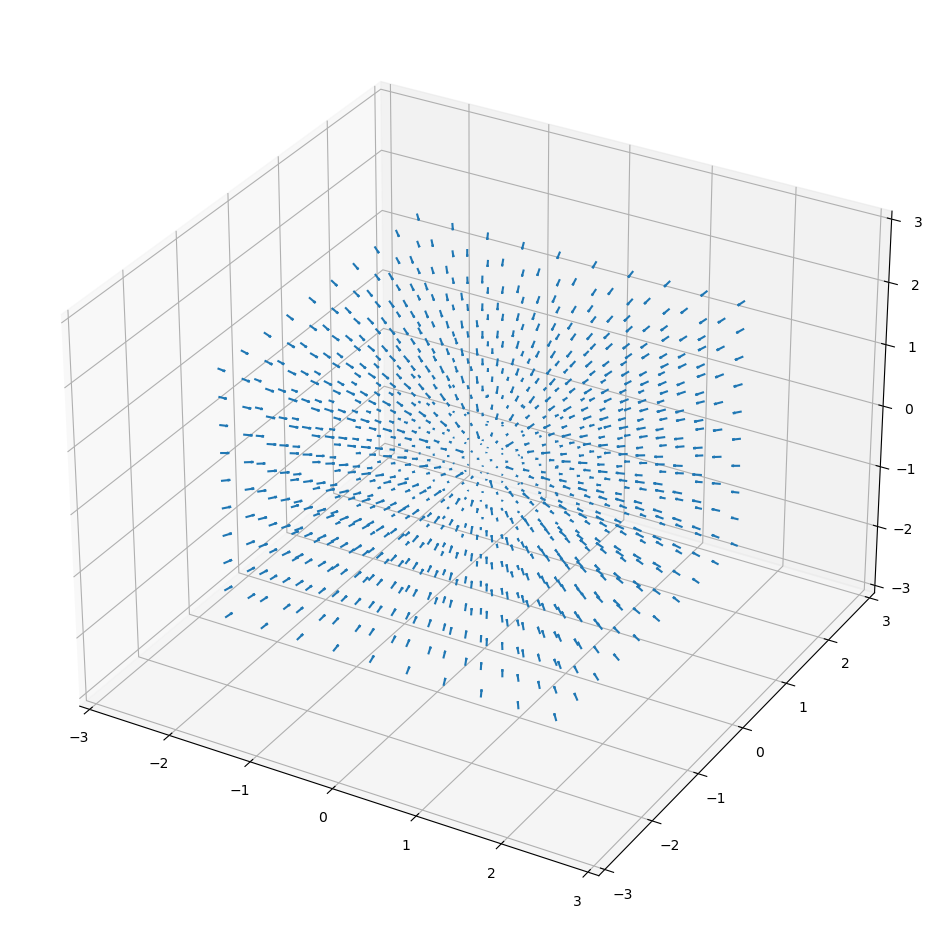

In [66]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, x3))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

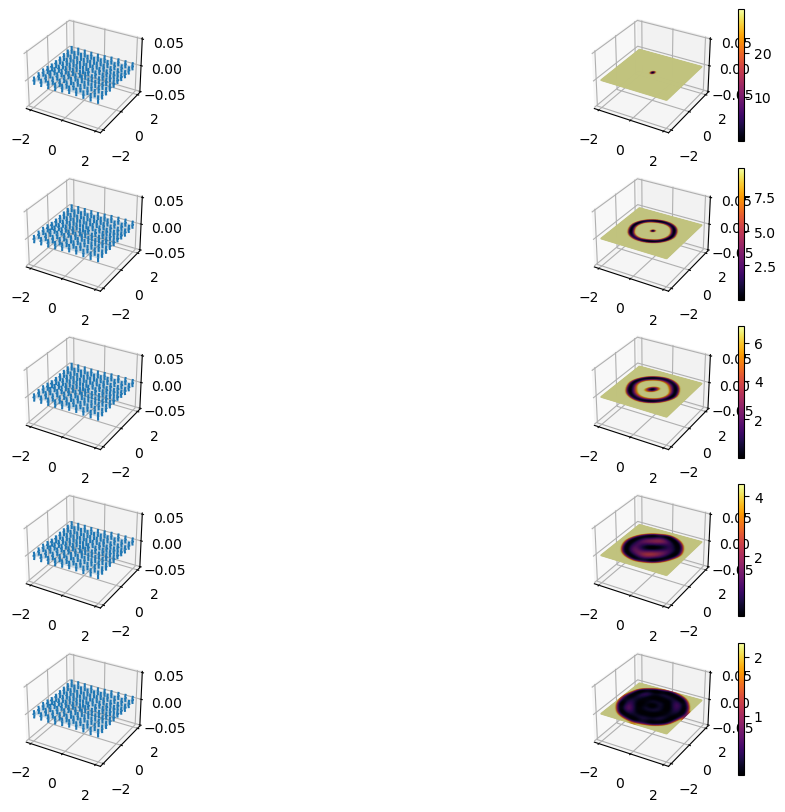

In [67]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,x2))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],Fx)
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,Fx)
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $T$

In [82]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
repeats = 2**3
batch_size = samples_per_x0*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [83]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        x3 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        
        x0 = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))).T
        x0 = jnp.repeat(x0, samples_per_x0, axis=0)
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x3 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        
        xT = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))).T
        
        yield jnp.hstack((x0, xT))

In [84]:
global x0s
x0s = tile(x0,batch_size)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        _dts = dts(T=T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]
        charts = chartss[-1]
        Fx0s = x0s[0]
        x0s = (jnp.repeat(samples[::samples_per_x0],samples_per_x0,axis=0),
               jnp.repeat(charts[::samples_per_x0],samples_per_x0,axis=0))
        yield jnp.hstack((Fx0s,samples))

In [85]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(80), jax.nn.tanh,
        hk.Linear(40), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(3),
    ])
#     y = jnp.squeeze(jax.vmap(to_TM)(x.reshape([-1,2*M.emb_dim])[:,M.emb_dim:],model(x.reshape([-1,2*M.emb_dim]))))
    y = model(x)
    return y

In [86]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    Fx0s = data[:,0:3]
    Fxts = data[:,3:2*3]
    #true_s = vmap(lambda x0, x1, t: to_TM(x0,grad_log_p_sm(x0, x1, t)))(Fx0s, Fxts, ts)
    true_s = vmap(lambda x0, x1: grad_log_p_sm(x0, x1, T))(Fx0s, Fxts)
    
    return jnp.linalg.norm(s-true_s)**2

In [87]:
#generator = generator_unif
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*3]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 1337.746.
[Step 20], epoch 1, training loss: 1238.700.
[Step 30], epoch 1, training loss: 1087.363.
[Step 40], epoch 2, training loss: 953.030.
[Step 50], epoch 3, training loss: 788.210.
[Step 60], epoch 3, training loss: 674.566.
[Step 70], epoch 4, training loss: 505.035.
[Step 80], epoch 5, training loss: 453.385.
[Step 90], epoch 5, training loss: 345.227.
[Step 100], epoch 6, training loss: 327.995.
[Step 110], epoch 6, training loss: 259.237.
[Step 120], epoch 7, training loss: 169.948.
[Step 130], epoch 8, training loss: 165.949.
[Step 140], epoch 8, training loss: 144.726.
[Step 150], epoch 9, training loss: 221.597.
[Step 160], epoch 10, training loss: 165.984.
[Step 170], epoch 10, training loss: 161.414.
[Step 180], epoch 11, training loss: 132.858.
[Step 190], epoch 11, training loss: 129.631.
[Step 200], epoch 12, training loss: 120.776.
[Step 210], epoch 13, training loss: 145.070.
[Step 220], epoc

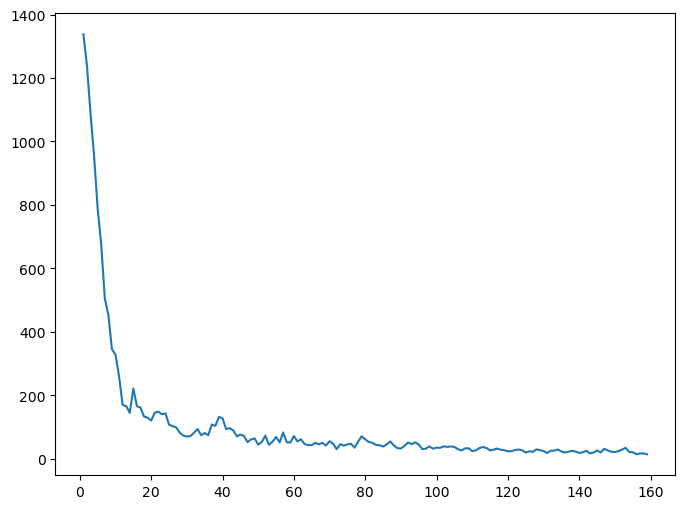

In [88]:
plt.figure(figsize=(8,6))
plt.plot(loss)

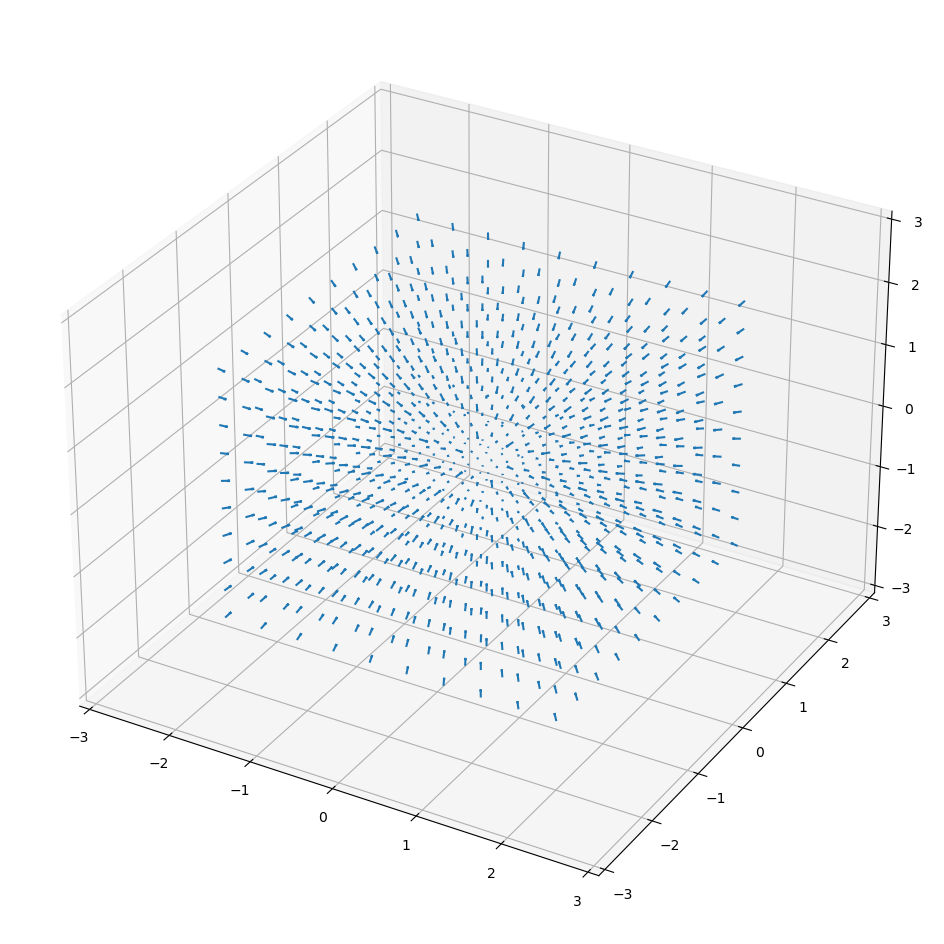

In [89]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, 
                                                                     jnp.hstack((x0[0],x3))))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

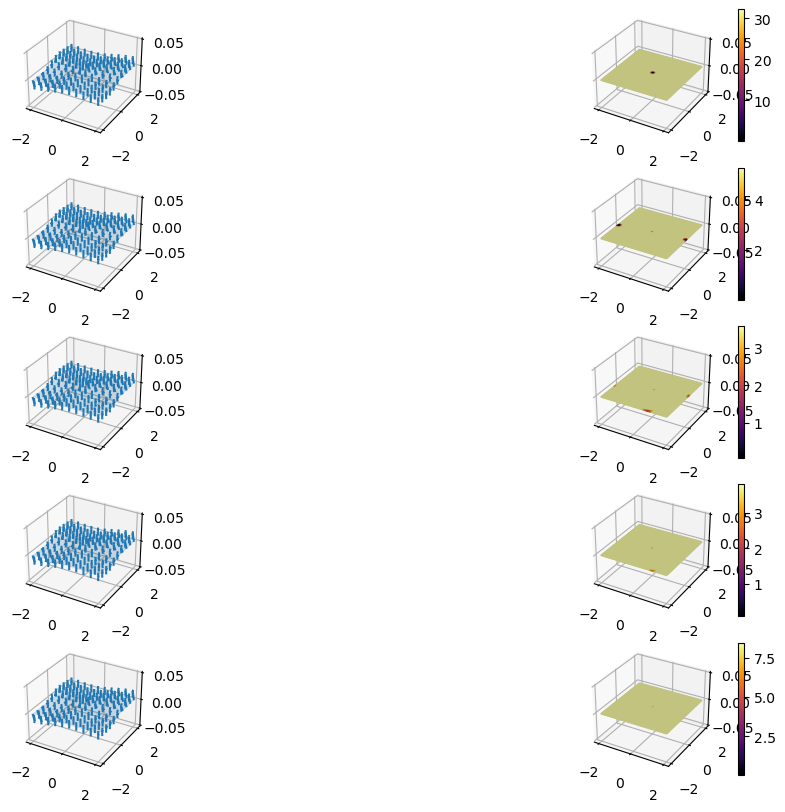

In [90]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0],x2))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0],Fx)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0],Fx)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$

In [91]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
ts_per_batch = 2**4
repeats = 2**5
batch_size = ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [92]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x3 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        
        xT = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))).T
        t = np.repeat(np.random.uniform(low = 0.0, high = 1.0, size=ts_per_batch), repeats)
        
        yield jnp.hstack((xT, t.reshape(-1, 1)))

In [94]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = repeats
        _dts = dts(T=max_T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))        
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([49,99])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((samples.reshape((-1,M.dim)),
                         jnp.repeat(ts.reshape((-1,1)),N,axis=1).reshape((-1,1))
                        ))

In [95]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(30), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(3),
    ])
    y = model(x)
    return y

In [96]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    Fxts = data[:,0:3]
    ts = data[:,-1]
    #true_s = vmap(lambda x0, x1, t: to_TM(x0,grad_log_p_sm(x0, x1, t)))(Fx0s, Fxts, ts)
    true_s = vmap(lambda x1, t: grad_log_p_sm(x0[-1], x1, t))(Fxts, ts)
    
    return jnp.linalg.norm(s-true_s)**2

In [97]:
#generator = generator_unif
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,3+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 3996.060.
[Step 20], epoch 1, training loss: 2150.783.
[Step 30], epoch 1, training loss: 3546.531.
[Step 40], epoch 2, training loss: 3722.233.
[Step 50], epoch 3, training loss: 12699.037.
[Step 60], epoch 3, training loss: 4511.093.
[Step 70], epoch 4, training loss: 1521.908.
[Step 80], epoch 5, training loss: 1452.240.
[Step 90], epoch 5, training loss: 2934.676.
[Step 100], epoch 6, training loss: 1779.391.
[Step 110], epoch 6, training loss: 3281.936.
[Step 120], epoch 7, training loss: 10230.264.
[Step 130], epoch 8, training loss: 905.835.
[Step 140], epoch 8, training loss: 2241.312.
[Step 150], epoch 9, training loss: 9278.409.
[Step 160], epoch 10, training loss: 12601.417.
[Step 170], epoch 10, training loss: 1233.729.
[Step 180], epoch 11, training loss: 1569.516.
[Step 190], epoch 11, training loss: 7199.671.
[Step 200], epoch 12, training loss: 2062.582.
[Step 210], epoch 13, training loss: 6625.7

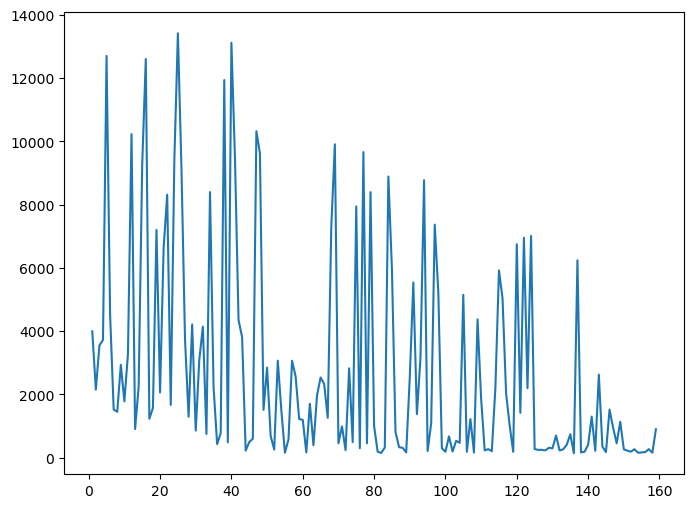

In [98]:
plt.figure(figsize=(8,6))
plt.plot(loss)

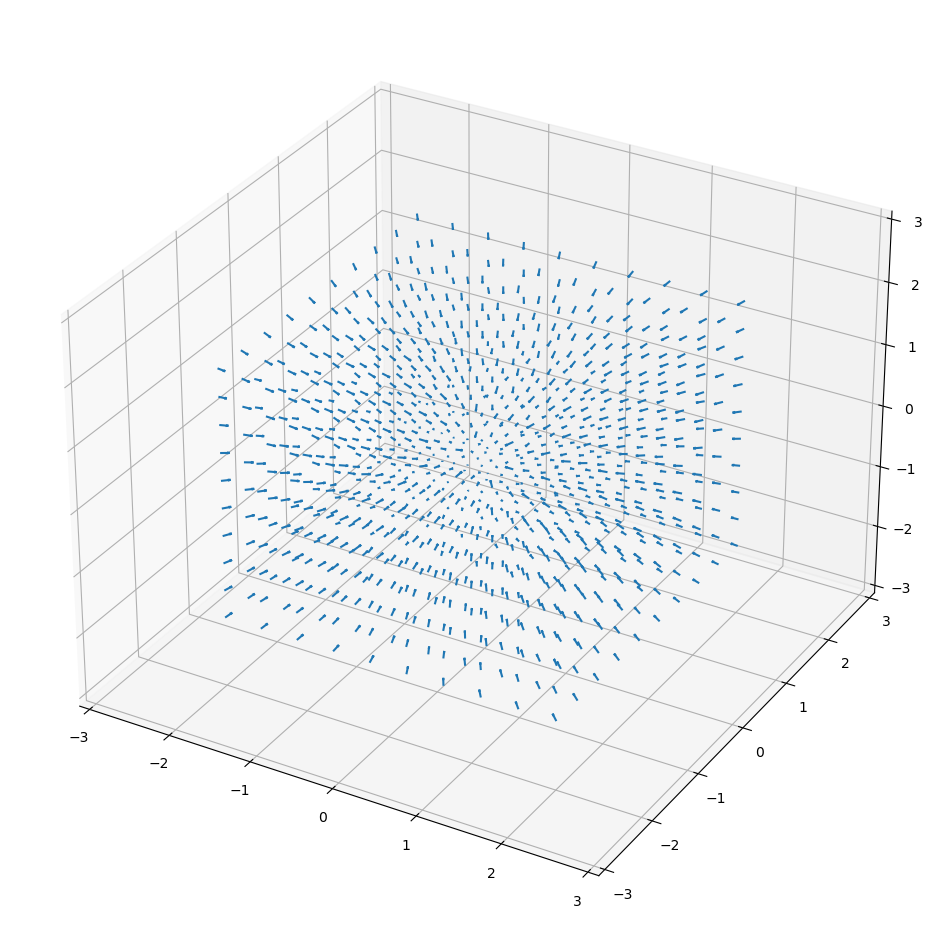

In [99]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, 
                                                                     jnp.hstack((x3,T))))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

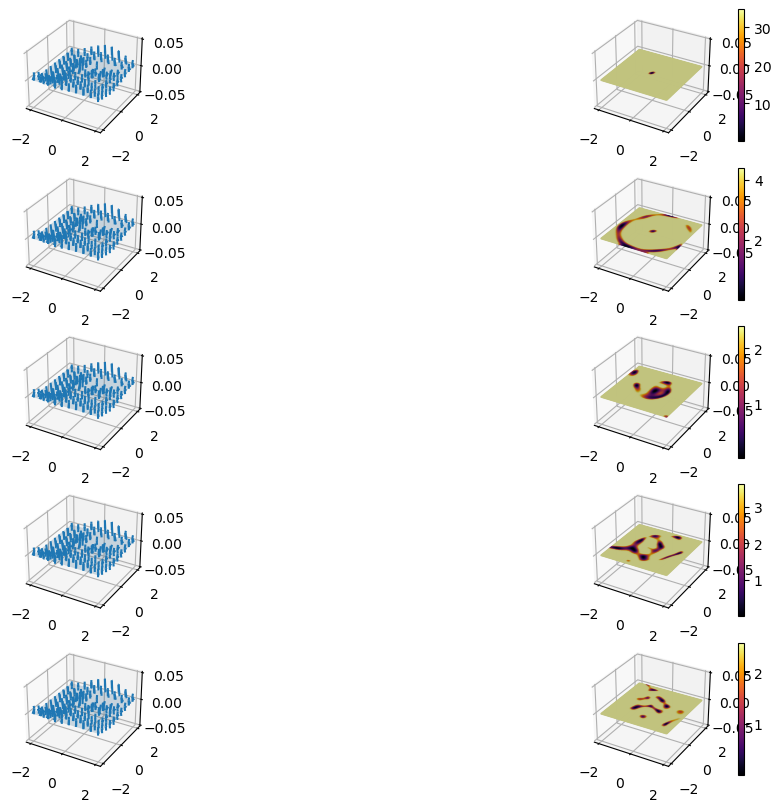

In [100]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x2,T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((Fx,T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((Fx,T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ in general

In [101]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
ts_per_batch = 2**7
repeats = 2**3
batch_size = samples_per_x0*ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [102]:
#Uniform generator
def generator_unif():
    while True:
        """Generates batches of samples."""
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        x3 = np.random.normal(loc = 0.0, scale = 2.0, size=repeats)
        
        x0 = jnp.repeat(jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))).T,
                        ts_per_batch*samples_per_x0, axis=0)
        
        x1 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x2 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        x3 = np.random.normal(loc = 0.0, scale = 2.0, size=batch_size)
        
        xT = jnp.concatenate((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))).T
        t = np.repeat(np.random.uniform(low = 0.0, high = 1.0, size=ts_per_batch), repeats*samples_per_x0)
        
        yield jnp.hstack((x0, xT, t.reshape(-1, 1)))

In [111]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = samples_per_x0*repeats
        _dts = dts(T=max_T, n_steps=1000)
        global x0s
        (ts,xss,chartss,*_) = product((jnp.repeat(x0s[0],samples_per_x0,axis=0),jnp.repeat(x0s[1],samples_per_x0,axis=0)),
                                      _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        Fx0s = x0s[0]
        x0s = (xss[-1,::samples_per_x0],chartss[-1,::samples_per_x0])
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([-1,-1])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((jnp.tile(jnp.repeat(Fx0s,samples_per_x0,axis=0),(ts_per_batch,1)),
                         samples.reshape(-1, M.dim),
                         jnp.repeat(ts,N).reshape((-1,1))
                        ))

In [112]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(400), jax.nn.tanh,
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(100), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(3),
    ])
    
    y = model(x)
    
    return y

In [113]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    Fx0s = data[:,0:3]
    Fxts = data[:,3:2*3]
    ts = data[:,-1]
    #true_s = vmap(lambda x0, x1, t: to_TM(x0,grad_log_p_sm(x0, x1, t)))(Fx0s, Fxts, ts)
    true_s = vmap(lambda x0, x1, t: grad_log_p_sm(x0, x1, t))(Fx0s, Fxts, ts)
    
    return jnp.linalg.norm(s-true_s)**2

In [114]:
#generator = generator_unif
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*3+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: 399275.344.
[Step 20], epoch 1, training loss: 1065549.875.
[Step 30], epoch 1, training loss: 374982.812.
[Step 40], epoch 2, training loss: 594147.938.
[Step 50], epoch 3, training loss: 454140.906.
[Step 60], epoch 3, training loss: 679120.375.
[Step 70], epoch 4, training loss: 429022.906.
[Step 80], epoch 5, training loss: 382189.906.
[Step 90], epoch 5, training loss: 451199.750.
[Step 100], epoch 6, training loss: 186105.562.
[Step 110], epoch 6, training loss: 337745.844.
[Step 120], epoch 7, training loss: 472610.250.
[Step 130], epoch 8, training loss: 375428.375.
[Step 140], epoch 8, training loss: 219866.656.
[Step 150], epoch 9, training loss: 925072.625.
[Step 160], epoch 10, training loss: 233258.281.
[Step 170], epoch 10, training loss: 209306.172.
[Step 180], epoch 11, training loss: 367836.250.
[Step 190], epoch 11, training loss: 361551.625.
[Step 200], epoch 12, training loss: 222548.844.
[Ste

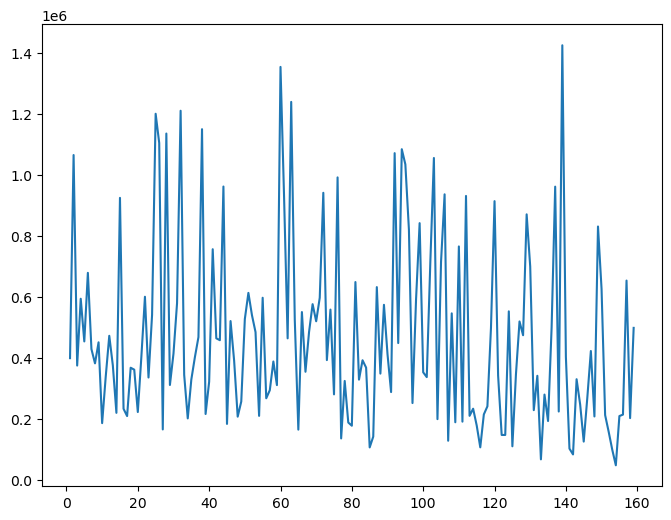

In [115]:
plt.figure(figsize=(8,6))
plt.plot(loss)

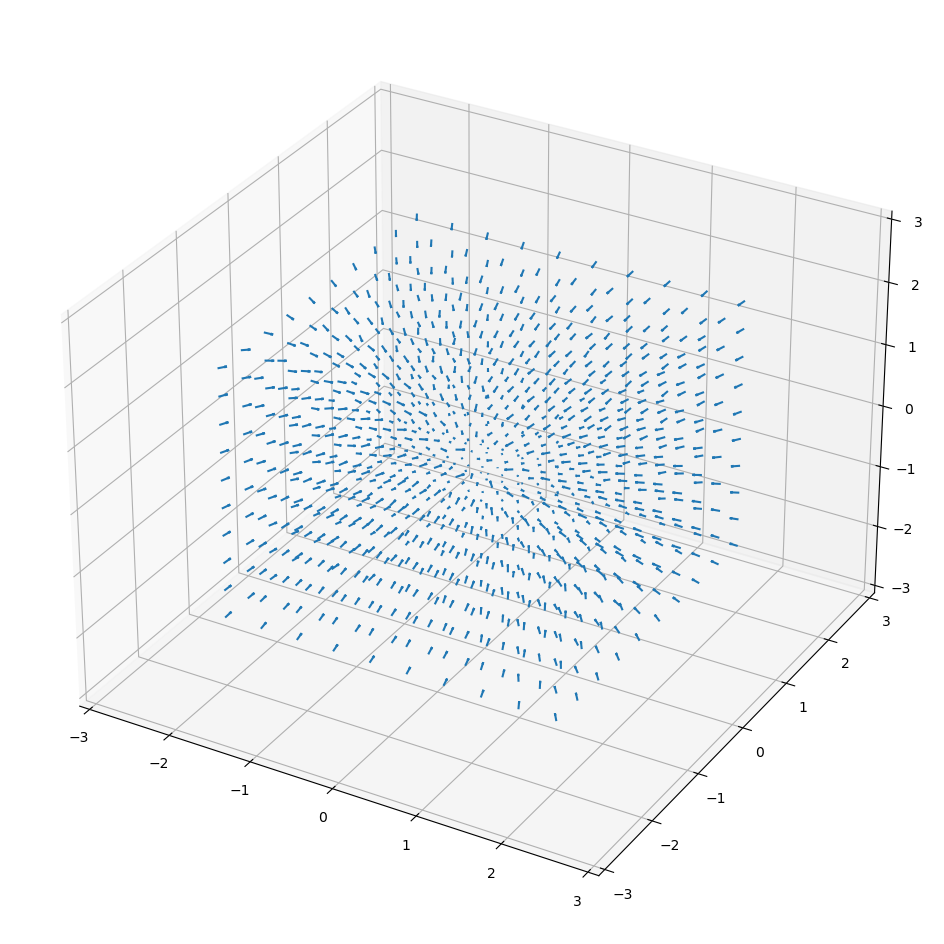

In [116]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, 
                                                                     jnp.hstack((x0[0], x3,T))))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

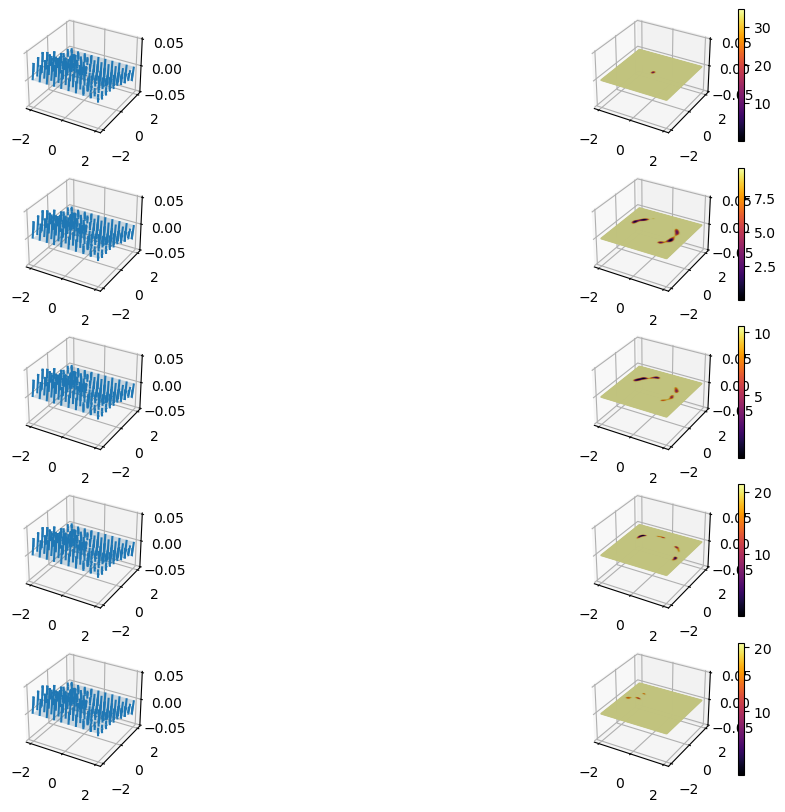

In [117]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0], x2,T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0], Fx,T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0], Fx,T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

## Learning $\nabla_{x}\log p$

Following "Riemannian Score-Based Generative Modelling" by Bortoli et. al. it follows that

\begin{equation}
    \nabla_{x} \log p(x, y, t) = \int_{\mathcal{M}} \nabla_{x}p(x,y,t) \,\mathbb{P}_{s|t}(x_{t}, \,dx_{s}),
\end{equation}

can be minimized as

\begin{equation}
    \mathcal{l}_{t|s} = \int_{\mathcal{M}^{2}} ||\nabla_{x} \log p(x,y,t) - s_{\theta}(x,t)||,
\end{equation}

where $s_{\theta}$ is a neural network with parameters $\theta$. Using integration by parts it follows that

\begin{equation}
    \mathcal{l}_{t|s} = \int_{\mathcal{M}} \left(||s(x,t)||^{2} + 2\text{div}\left(s_{t}\right)(x_{t})\right)\,d\mathbb{P}_{t}(x_{t})+\int_{\mathcal{M}^{2}}||\nabla_{x}\log p_{t|s}(x_{t}|x_{s})\,d\mathbb{P}_{s,t}(x_{s},x_{t}),
\end{equation}

where the latter term is independent of $s_{\theta}$.

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$ and $T$

In [118]:
#Hyper parameters
learning_rate = 0.001
epochs = 100
batch_size = 2**5
samples_size = batch_size*2**4
maxiter = epochs * samples_size // batch_size

In [119]:
#Brownian generator
_dts = dts(T=T)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        (ts,xss,chartss,*_) = product(tile(x0,N),
                                      _dts,
                                      dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]

        yield samples

In [126]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(40), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(10), jax.nn.tanh,
        hk.Linear(3),
    ])
#     y = jax.vmap(to_TM)(x.reshape([-1,M.emb_dim]),model(x.reshape([-1,M.emb_dim]))).reshape(x.shape)
    y = model(x)
    return y

In [127]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params, data)
    (xs,charts) = jax.vmap(get_coords)(data)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda x,chart,s: M.div((x,chart),
                                            lambda x: net.apply(params,x[0])))(xs,charts,s)
#     # plot
#     newfig()
#     M.plot()
#     for i in range(xs.shape[0]):
#         M.plotx((xs[i],charts[i]))
#     plt.show()
    return jnp.mean(norm2s+2.0*divs)

In [128]:
#Data loader
generator = generator_bm #Generate from Browninan motion in x0
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,3]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate) #Adam Optimizer
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -2.823.
[Step 20], epoch 1, training loss: -2.798.
[Step 30], epoch 1, training loss: -3.987.
[Step 40], epoch 2, training loss: -3.680.
[Step 50], epoch 3, training loss: -4.105.
[Step 60], epoch 3, training loss: -4.448.
[Step 70], epoch 4, training loss: -4.912.
[Step 80], epoch 5, training loss: -5.253.
[Step 90], epoch 5, training loss: -6.108.
[Step 100], epoch 6, training loss: -4.193.
[Step 110], epoch 6, training loss: -5.129.
[Step 120], epoch 7, training loss: -6.227.
[Step 130], epoch 8, training loss: -4.912.
[Step 140], epoch 8, training loss: -5.975.
[Step 150], epoch 9, training loss: -4.547.
[Step 160], epoch 10, training loss: -5.797.
[Step 170], epoch 10, training loss: -5.448.
[Step 180], epoch 11, training loss: -5.481.
[Step 190], epoch 11, training loss: -6.468.
[Step 200], epoch 12, training loss: -5.820.
[Step 210], epoch 13, training loss: -4.502.
[Step 220], epoch 13, training loss: -3.

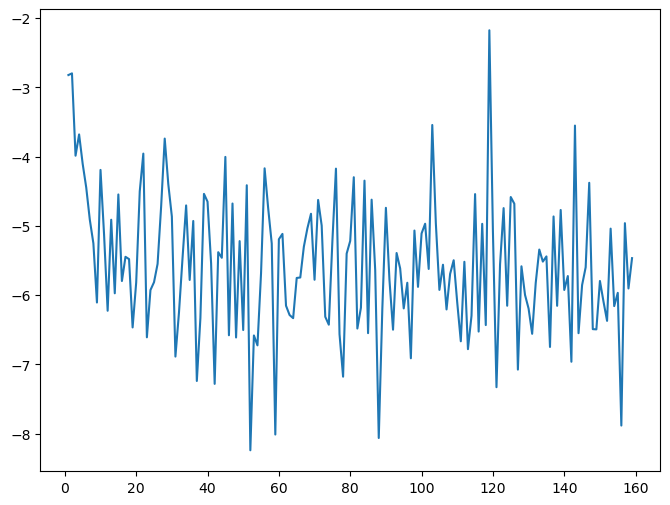

In [129]:
plt.figure(figsize=(8,6))
plt.plot(loss)

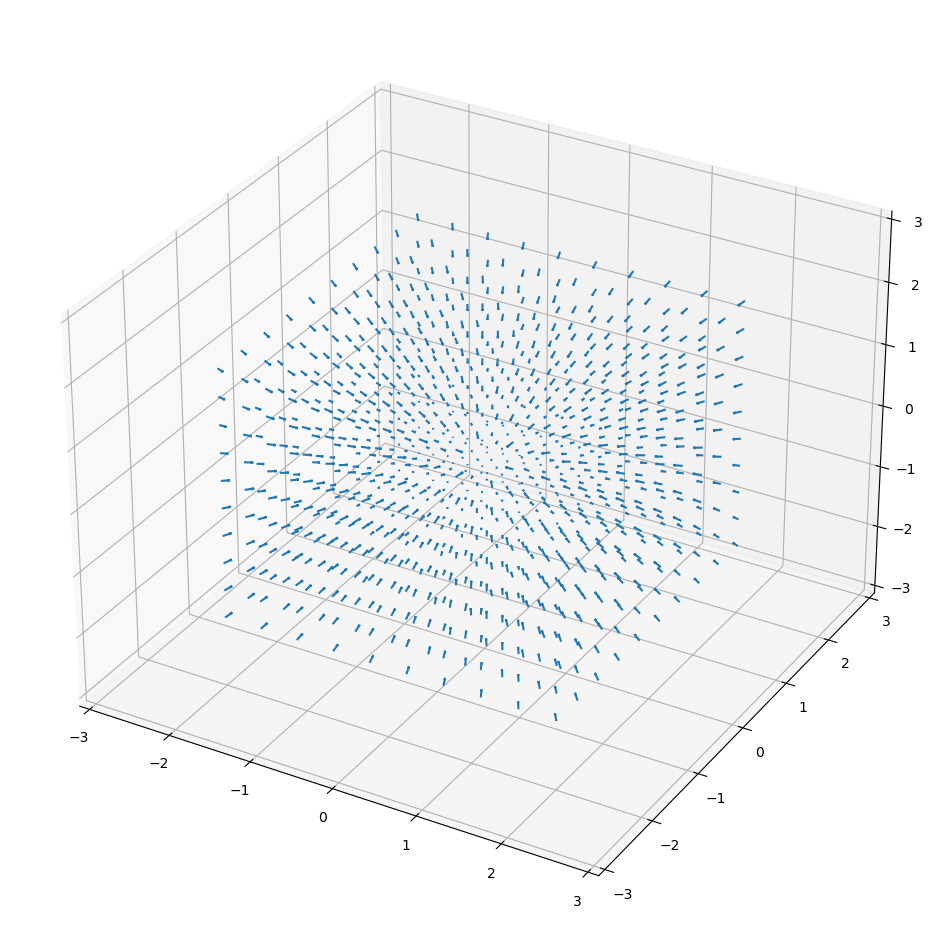

In [130]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, x3))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

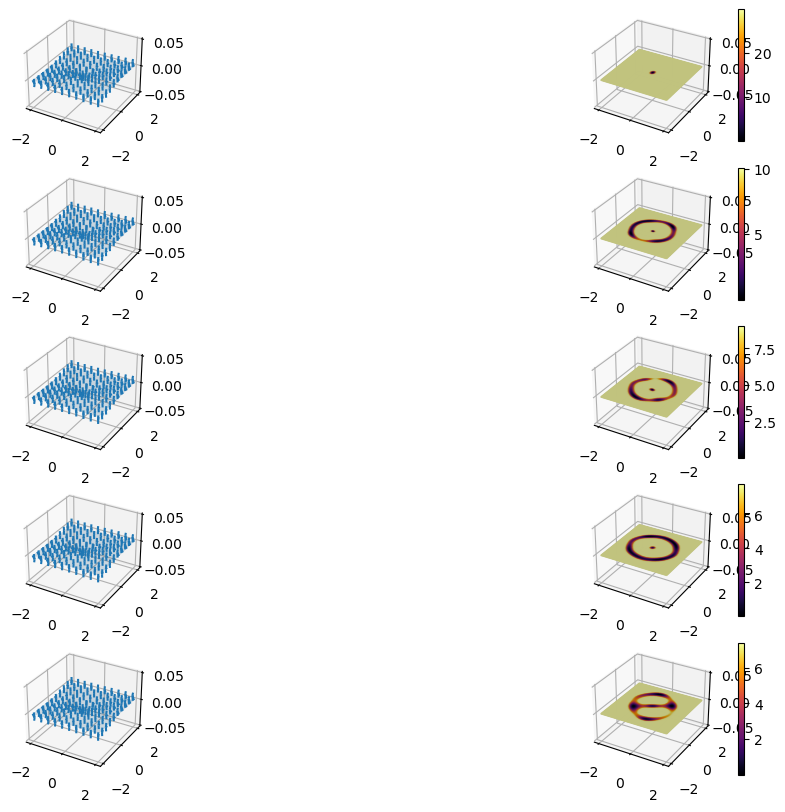

In [131]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,x2))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],Fx)
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,Fx)
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $T$

In [132]:
#Hyper parameters
learning_rate = 0.01 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
repeats = 2**3
batch_size = samples_per_x0*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [133]:
global x0s
x0s = tile(x0,batch_size)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = batch_size
        _dts = dts(T=T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        samples = xss[-1]
        charts = chartss[-1]
        Fx0s = x0s[0]
        x0s = (jnp.repeat(samples[::samples_per_x0],samples_per_x0,axis=0),
               jnp.repeat(charts[::samples_per_x0],samples_per_x0,axis=0))
        yield jnp.hstack((Fx0s,samples))

In [134]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(80), jax.nn.tanh,
        hk.Linear(40), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(3),
    ])
#     y = jnp.squeeze(jax.vmap(to_TM)(x.reshape([-1,2*M.emb_dim])[:,M.emb_dim:],model(x.reshape([-1,2*M.emb_dim]))))
    y = model(x)
    return y

In [135]:
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fx0s = data[:,0:3]
    Fxts = data[:,3:]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda Fx0,xt,chartt: M.div((xt,chartt),
                                                lambda x: net.apply(params,jnp.hstack((Fx0,x[0]))))
                   )(Fx0s,xts,chartts)
    return jnp.mean(norm2s+2.0*divs)

In [136]:
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,2*3]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -4.351.
[Step 20], epoch 1, training loss: -5.601.
[Step 30], epoch 1, training loss: -5.186.
[Step 40], epoch 2, training loss: -5.261.
[Step 50], epoch 3, training loss: -5.387.
[Step 60], epoch 3, training loss: -4.956.
[Step 70], epoch 4, training loss: -5.411.
[Step 80], epoch 5, training loss: -5.563.
[Step 90], epoch 5, training loss: -5.508.
[Step 100], epoch 6, training loss: -5.596.
[Step 110], epoch 6, training loss: -5.366.
[Step 120], epoch 7, training loss: -5.549.
[Step 130], epoch 8, training loss: -5.514.
[Step 140], epoch 8, training loss: -4.642.
[Step 150], epoch 9, training loss: -6.358.
[Step 160], epoch 10, training loss: -5.150.
[Step 170], epoch 10, training loss: -5.959.
[Step 180], epoch 11, training loss: -4.686.
[Step 190], epoch 11, training loss: -6.062.
[Step 200], epoch 12, training loss: -4.666.
[Step 210], epoch 13, training loss: -5.230.
[Step 220], epoch 13, training loss: -5.

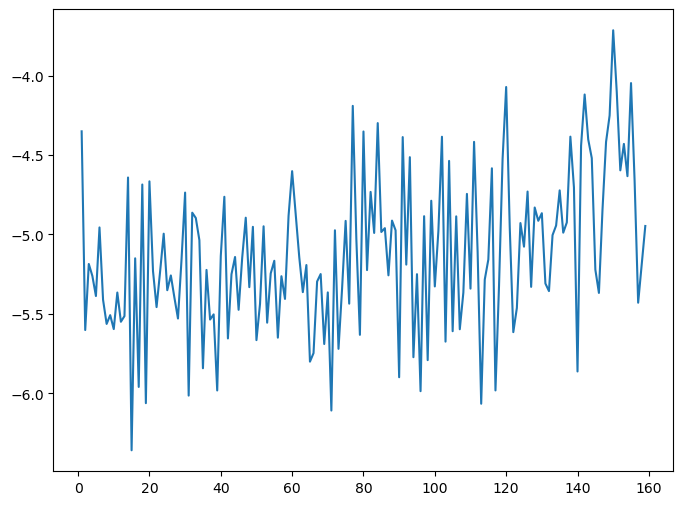

In [137]:
plt.figure(figsize=(8,6))
plt.plot(loss)

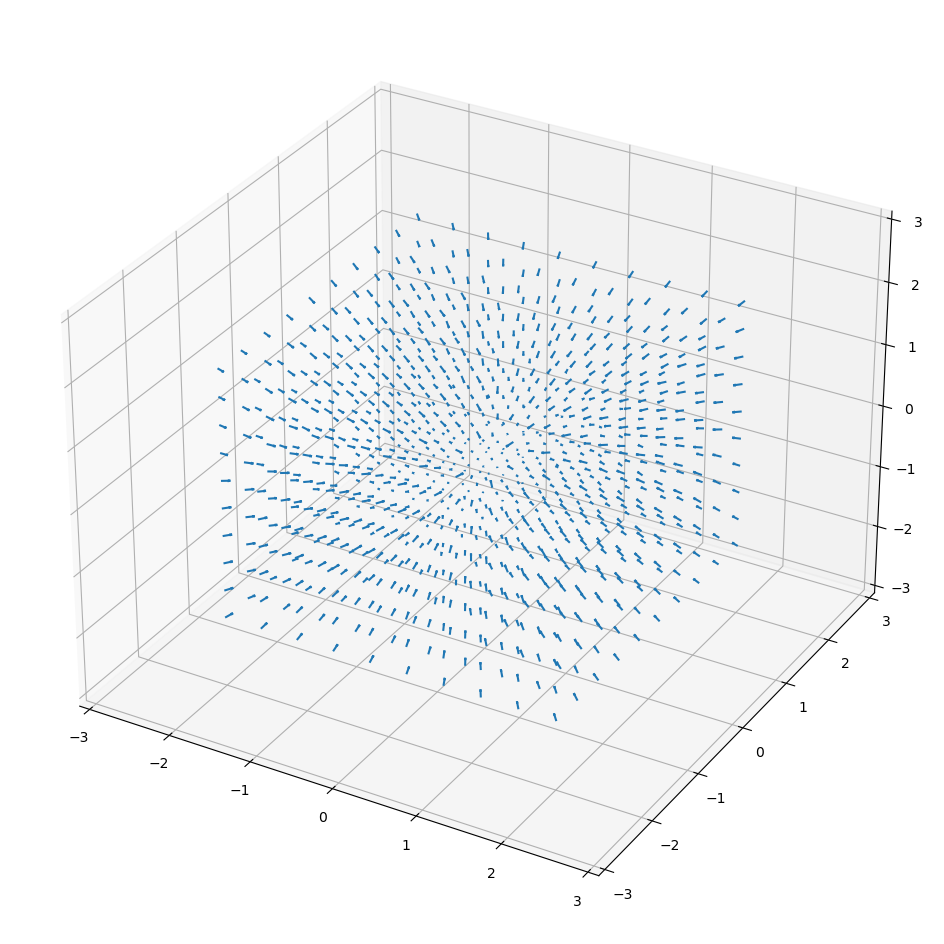

In [138]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, 
                                                                     jnp.hstack((x0[0],x3))))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

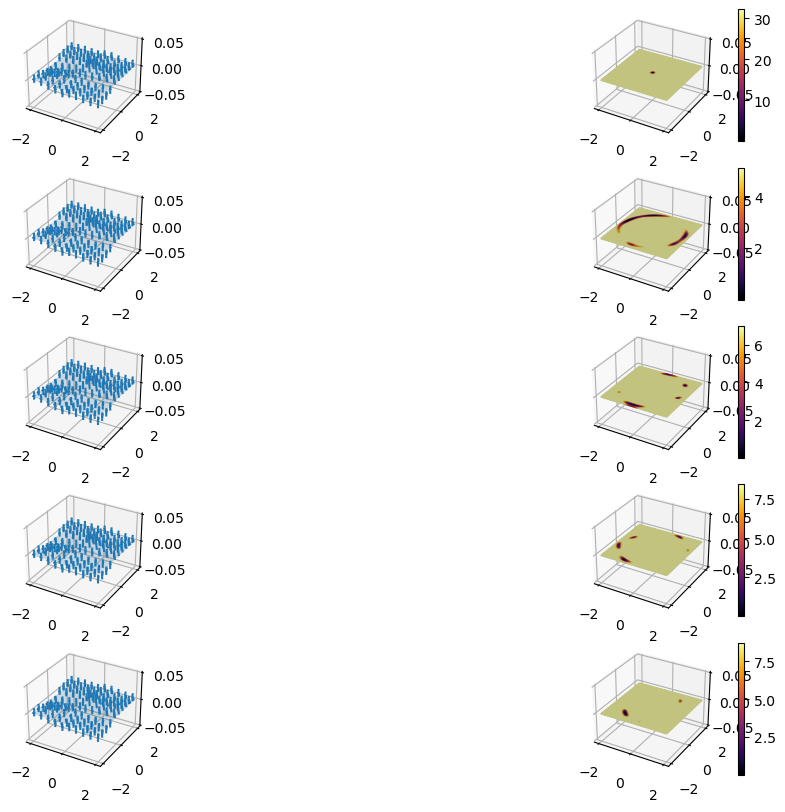

In [139]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0],x2))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0],Fx)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0],Fx)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ for fixed $x_{0}$

In [140]:
#Hyper parameters
learning_rate = 0.01 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
ts_per_batch = 2**4
repeats = 2**5
batch_size = ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [141]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = repeats
        _dts = dts(T=max_T)
        global x0s
        (ts,xss,chartss,*_) = product(x0s,_dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))        
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([49,99])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((samples.reshape((-1, M.dim)),
                         jnp.repeat(ts.reshape((-1,1)),N,axis=1).reshape((-1,1))
                        ))

In [142]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(30), jax.nn.tanh,
        hk.Linear(20), jax.nn.tanh,
        hk.Linear(3),
    ])
    y = model(x)
    return y

In [143]:
#Loss function
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fxts = data[:,0:3]
    ts = data[:,-1]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda xt,chartt,t: M.div((xt,chartt),
                                              lambda x: net.apply(params,jnp.hstack((x[0],t))))
                   )(xts,chartts,ts)
    return jnp.mean(norm2s+2.0*divs)

In [144]:
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,3+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -5.665.
[Step 20], epoch 1, training loss: -6.223.
[Step 30], epoch 1, training loss: -8.997.
[Step 40], epoch 2, training loss: -5.593.
[Step 50], epoch 3, training loss: -7.531.
[Step 60], epoch 3, training loss: -12.189.
[Step 70], epoch 4, training loss: -6.743.
[Step 80], epoch 5, training loss: -8.689.
[Step 90], epoch 5, training loss: -7.265.
[Step 100], epoch 6, training loss: -10.353.
[Step 110], epoch 6, training loss: -8.561.
[Step 120], epoch 7, training loss: -5.773.
[Step 130], epoch 8, training loss: -11.435.
[Step 140], epoch 8, training loss: -7.640.
[Step 150], epoch 9, training loss: -11.089.
[Step 160], epoch 10, training loss: -11.792.
[Step 170], epoch 10, training loss: -12.073.
[Step 180], epoch 11, training loss: -6.082.
[Step 190], epoch 11, training loss: -7.128.
[Step 200], epoch 12, training loss: -10.368.
[Step 210], epoch 13, training loss: -10.373.
[Step 220], epoch 13, training l

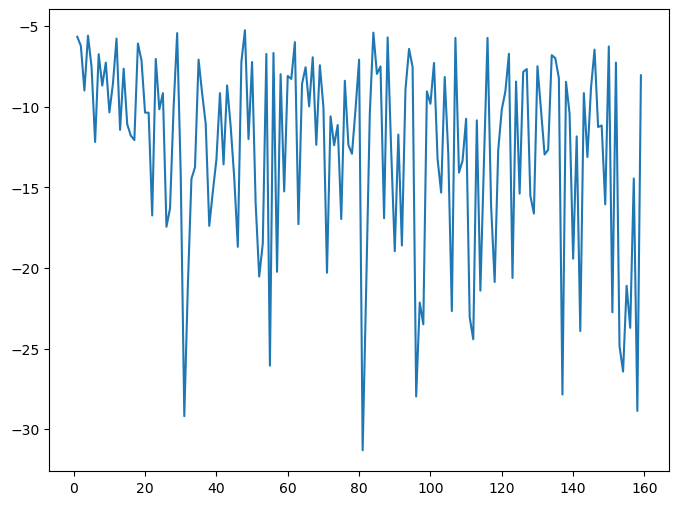

In [145]:
plt.figure(figsize=(8,6))
plt.plot(loss)

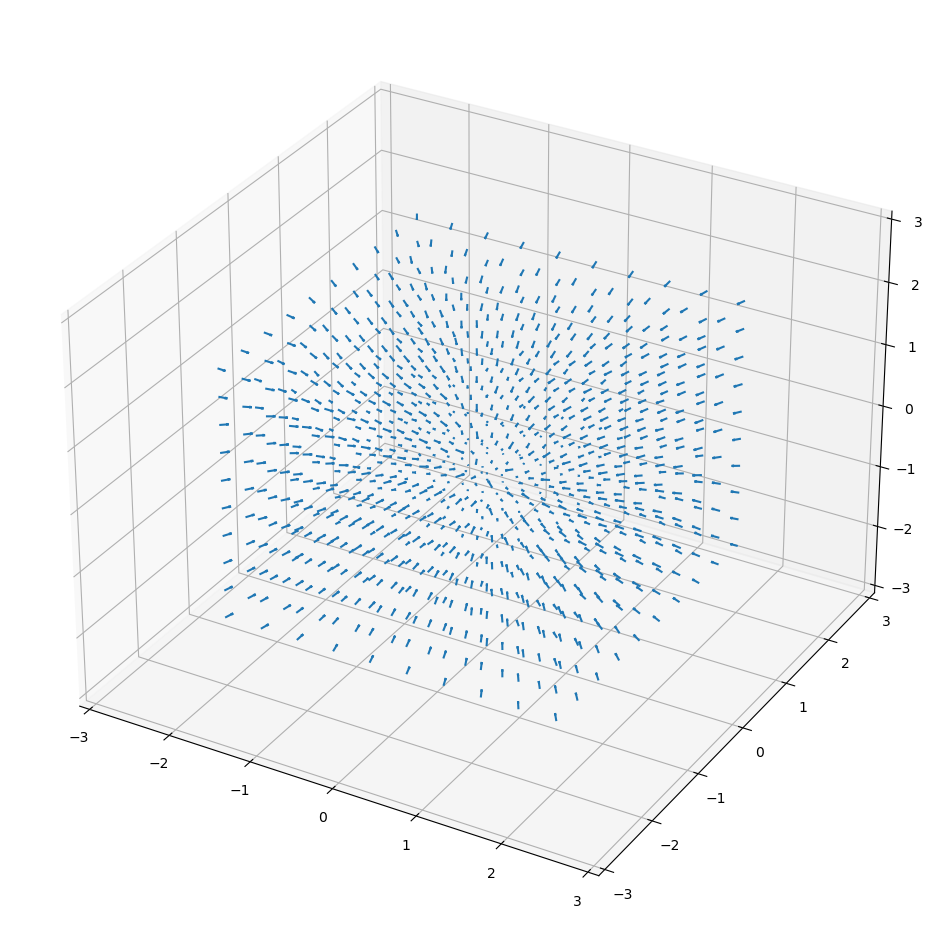

In [146]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, 
                                                                     jnp.hstack((x3,T))))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

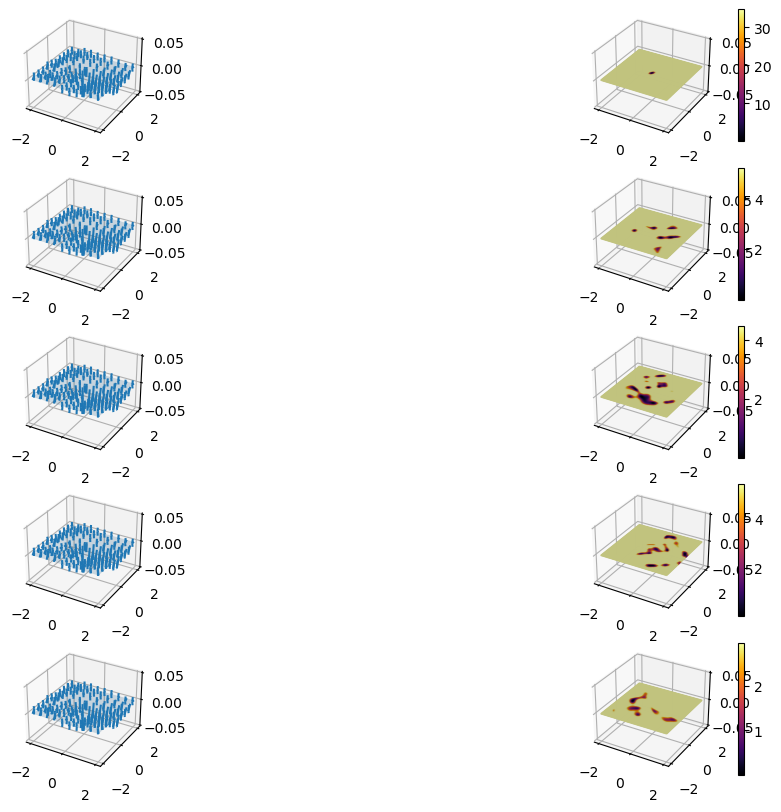

In [147]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x2,T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((Fx,T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((Fx,T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

### Learning $\nabla_{x}\log p$ general

In [153]:
#Hyper parameters
learning_rate = 0.001 # Learning rate for optimizer
epochs = 100 # Number of passes over the dataset
samples_per_x0 = 2**5
ts_per_batch = 32
repeats = 2**3
batch_size = samples_per_x0*ts_per_batch*repeats
samples_size = batch_size*2**4 # Total number of samples per epoch
maxiter = epochs * samples_size // batch_size

In [154]:
global x0s
x0s = tile(x0,repeats)

def generator_bm():
    while True:
        """Generates batches of samples."""
        N = samples_per_x0*repeats
        _dts = dts(T=1.)
        global x0s
        (ts,xss,chartss,*_) = product((jnp.repeat(x0s[0],samples_per_x0,axis=0),jnp.repeat(x0s[1],samples_per_x0,axis=0)),
                                      _dts,dWs(N*M.dim,_dts).reshape(-1,N,M.dim),jnp.repeat(1.,N))
        Fx0s = x0s[0]
        x0s = (xss[-1,::samples_per_x0],chartss[-1,::samples_per_x0])
        inds = np.random.choice(range(_dts.shape[0]),ts_per_batch,replace=False)
#         inds = jnp.arange(0,ts.shape[0]+1,ts.shape[0]//ts_per_batch)[1:]-1
#         inds = jnp.array([-1,-1])
        ts = ts[inds]
        samples = xss[inds]
        charts = chartss[inds]
        yield jnp.hstack((jnp.tile(jnp.repeat(Fx0s,samples_per_x0,axis=0),(ts_per_batch,1)),
                         samples.reshape(-1, M.dim),
                         jnp.repeat(ts,N).reshape((-1,1))
                        ))

In [155]:
#Network
def net_f(x):
    """Create model."""
    model = hk.Sequential([
        hk.Linear(400), jax.nn.tanh,
        hk.Linear(200), jax.nn.tanh,
        hk.Linear(100), jax.nn.tanh,
        hk.Linear(50), jax.nn.tanh,
        hk.Linear(3),
    ])
    
    y = model(x)
    
    return y

In [156]:
def loss_fun(params, data):
    """ compute loss."""
    s = net.apply(params,data)
    Fx0s = data[:,0:3]
    Fxts = data[:,3:3*2]
    ts = data[:,-1]
    (xts,chartts) = jax.vmap(get_coords)(Fxts)
    norm2s = jax.vmap(lambda s: jnp.sum(jnp.square(s)))(s)
    divs = jax.vmap(lambda Fx0,xt,chartt,t: M.div((xt,chartt),
                                                  lambda x: net.apply(params,jnp.hstack((Fx0,x[0],t))))
                   )(Fx0s,xts,chartts,ts)
    return jnp.mean(norm2s+2.0*divs)

In [157]:
generator = generator_bm
ds = tf.data.Dataset.from_generator(generator,output_types=tf.float32,output_shapes=([batch_size,3*2+1]))
ds = iter(tfds.as_numpy(ds))

# initialize net and parameters
net = hk.without_apply_rng(hk.transform(net_f))
params = net.init(jax.random.PRNGKey(42), next(ds))

# Initialize solver.
params_lst = []
loss = []
def pre_update(params,state,*ars,**kwargs):
    if state.iter_num % 10 == 0:
        loss.append(state.value)
        params_lst.append(params)
        print(f"[Step {state.iter_num}], epoch {state.iter_num//(samples_size//batch_size)}, training loss: {state.value:.3f}.")
    return params,state

opt = optax.adam(learning_rate)
solver = jaxopt.OptaxSolver(opt=opt,fun=loss_fun,maxiter=maxiter,pre_update=pre_update)

# run training loop
state = solver.init_state(params)
params, state = solver.run_iterator(
    init_params=params, iterator=ds)


[Step 0], epoch 0, training loss: inf.
[Step 10], epoch 0, training loss: -3.581.
[Step 20], epoch 1, training loss: -5.720.
[Step 30], epoch 1, training loss: -4.283.
[Step 40], epoch 2, training loss: -5.216.
[Step 50], epoch 3, training loss: -5.703.
[Step 60], epoch 3, training loss: -6.278.
[Step 70], epoch 4, training loss: -6.140.
[Step 80], epoch 5, training loss: -5.936.
[Step 90], epoch 5, training loss: -6.365.
[Step 100], epoch 6, training loss: -5.352.
[Step 110], epoch 6, training loss: -5.554.
[Step 120], epoch 7, training loss: -5.342.
[Step 130], epoch 8, training loss: -5.994.
[Step 140], epoch 8, training loss: -6.388.
[Step 150], epoch 9, training loss: -6.628.
[Step 160], epoch 10, training loss: -5.536.
[Step 170], epoch 10, training loss: -6.009.
[Step 180], epoch 11, training loss: -5.399.
[Step 190], epoch 11, training loss: -5.379.
[Step 200], epoch 12, training loss: -6.793.
[Step 210], epoch 13, training loss: -8.614.
[Step 220], epoch 13, training loss: -7.

[Step 1810], epoch 113, training loss: -9.376.
[Step 1820], epoch 113, training loss: -8.687.
[Step 1830], epoch 114, training loss: -8.122.
[Step 1840], epoch 115, training loss: -8.830.
[Step 1850], epoch 115, training loss: -5.098.
[Step 1860], epoch 116, training loss: -6.610.
[Step 1870], epoch 116, training loss: -6.261.
[Step 1880], epoch 117, training loss: -6.339.
[Step 1890], epoch 118, training loss: -7.361.
[Step 1900], epoch 118, training loss: -7.081.
[Step 1910], epoch 119, training loss: -8.729.
[Step 1920], epoch 120, training loss: -9.666.
[Step 1930], epoch 120, training loss: -6.112.
[Step 1940], epoch 121, training loss: -5.680.
[Step 1950], epoch 121, training loss: -13.304.
[Step 1960], epoch 122, training loss: -6.919.
[Step 1970], epoch 123, training loss: -9.444.
[Step 1980], epoch 123, training loss: -9.578.
[Step 1990], epoch 124, training loss: -7.386.
[Step 2000], epoch 125, training loss: -6.597.
[Step 2010], epoch 125, training loss: -8.316.
[Step 2020],

[Step 3540], epoch 221, training loss: -10.517.
[Step 3550], epoch 221, training loss: -6.560.
[Step 3560], epoch 222, training loss: -10.938.
[Step 3570], epoch 223, training loss: -11.688.
[Step 3580], epoch 223, training loss: -12.912.
[Step 3590], epoch 224, training loss: -12.259.
[Step 3600], epoch 225, training loss: -17.318.
[Step 3610], epoch 225, training loss: -16.023.
[Step 3620], epoch 226, training loss: -15.560.
[Step 3630], epoch 226, training loss: -9.038.
[Step 3640], epoch 227, training loss: -12.712.
[Step 3650], epoch 228, training loss: -9.336.
[Step 3660], epoch 228, training loss: -8.365.
[Step 3670], epoch 229, training loss: -10.723.
[Step 3680], epoch 230, training loss: -12.032.
[Step 3690], epoch 230, training loss: -11.871.
[Step 3700], epoch 231, training loss: -8.854.
[Step 3710], epoch 231, training loss: -11.811.
[Step 3720], epoch 232, training loss: -8.023.
[Step 3730], epoch 233, training loss: -9.772.
[Step 3740], epoch 233, training loss: -13.097.

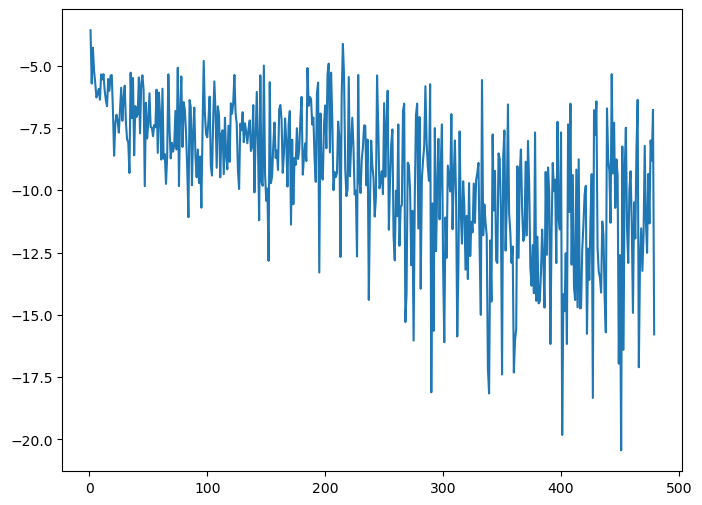

In [158]:
plt.figure(figsize=(8,6))
plt.plot(loss)

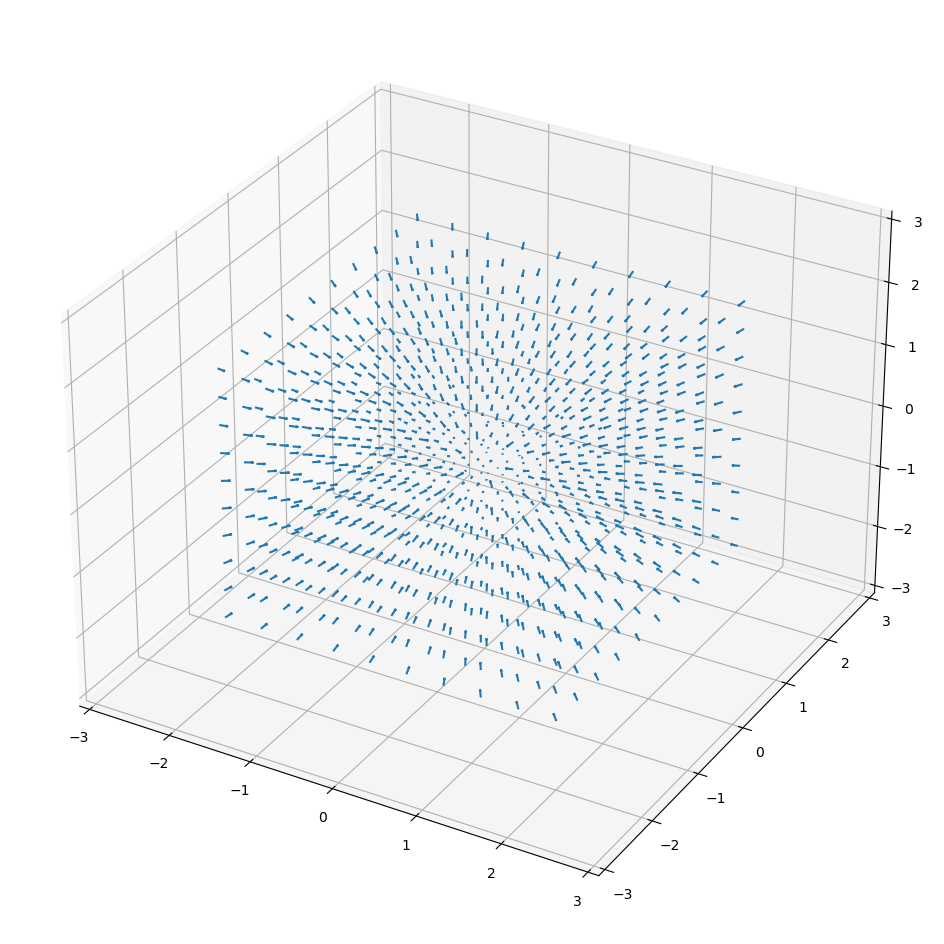

In [159]:
#define grid
lbnd = -2.0
ubnd = 2.0
N_points = 10
x1 = jnp.linspace(lbnd, ubnd, N_points)
x2 = jnp.linspace(lbnd, ubnd, N_points)
x3 = jnp.linspace(lbnd, ubnd, N_points)
X1, X2, X3 = jnp.meshgrid(x1, x2, x3)
X = jnp.transpose(jnp.concatenate((X1.reshape(1, N_points, N_points, N_points), 
                     X2.reshape(1, N_points, N_points, N_points), 
                     X3.reshape(1, N_points, N_points, N_points))), axes=(1,2,3,0))

grad_log = vmap(lambda x1: vmap(lambda x2: vmap(lambda x3: net.apply(params, 
                                                                     jnp.hstack((x0[0], x3,T))))(x2))(x1))(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X1, X2, X3, grad_log[:,:,:,0], grad_log[:,:,:,1], grad_log[:,:,:,2], length=0.1, normalize=True)
ax.set_xlim([-3.0, 3.0])
ax.set_ylim([-3.0, 3.0])
ax.set_zlim([-3.0, 3.0])
plt.show()

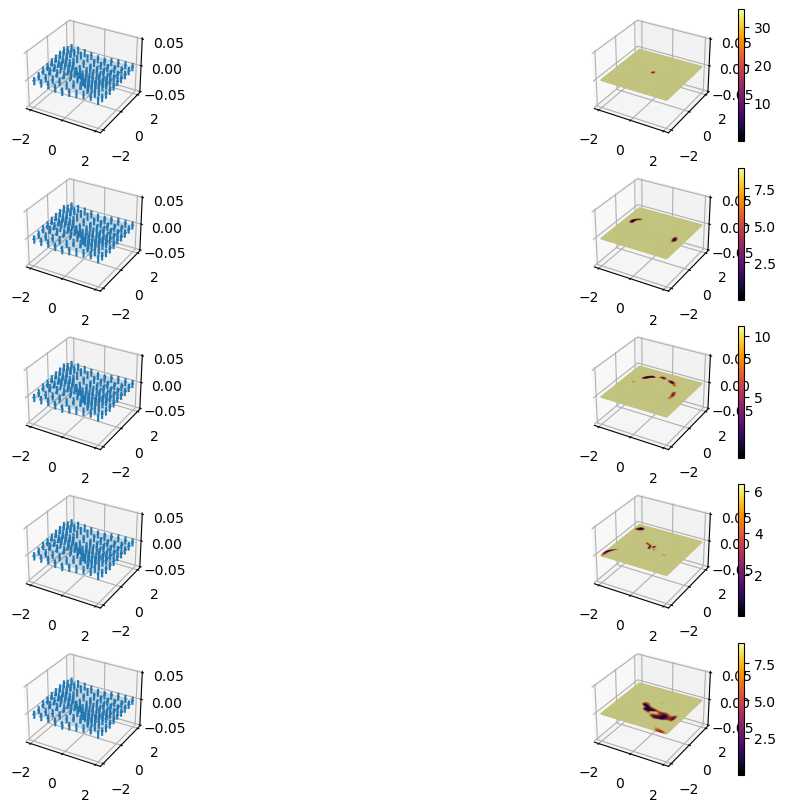

In [160]:
#Plot source: https://stackoverflow.com/questions/44594011/heat-map-on-unit-sphere

N_plots = 5

# Creating the theta and phi values.
intervals = 10

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_vec, X2_vec = jnp.meshgrid(x1, x2)
X3_vec = jnp.zeros_like(X1_vec)
X_vec = jnp.transpose(jnp.concatenate((X1_vec.reshape(1, intervals, intervals), 
                     X2_vec.reshape(1, intervals, intervals), 
                     X3_vec.reshape(1, intervals, intervals))), axes=(1,2,0))

grad_log = vmap(lambda x1: vmap(lambda x2: net.apply(params,jnp.hstack((x0[0], x2,T))))(x1))(X_vec)

# Creating the theta and phi values
intervals = 100

x1 = jnp.linspace(-2.0, 2.0, intervals)
x2 = jnp.linspace(-2.0, 2.0, intervals)
x3 = jnp.zeros(intervals)

# Creating the coordinate grid for the unit sphere.
X1_heat, X2_heat = jnp.meshgrid(x1, x2)
X3_heat = jnp.zeros_like(X1_heat)
X_heat = jnp.transpose(jnp.concatenate((X1_heat.reshape(1, intervals, intervals), 
                     X2_heat.reshape(1, intervals, intervals), 
                     X3_heat.reshape(1, intervals, intervals))), axes=(1,2,0))

theoretical_grad = lambda Fx: grad_log_p_sm(x0[-1], Fx, T)

# Creating the plot.
#fig, ax = plt.subplots(1,3)
fig = plt.figure(figsize=(12,12))
frac = int(len(params_lst)/N_plots)
for i in range(0,N_plots-1):
    numerical_grad = lambda Fx: net.apply(params_lst[i*frac],jnp.hstack((x0[0], Fx,T)))
    heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+1, projection='3d')
    ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
    ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
    ax = fig.add_subplot(N_plots+1, 2, 2*i+2, projection='3d')
    ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
    m.set_array(heat_map)
    fig.colorbar(m, ax=ax)
numerical_grad = lambda Fx: net.apply(params,jnp.hstack((x0[0], Fx,T)))
heat_map = vmap(lambda x2: vmap(lambda x1: jnp.sum((theoretical_grad(x1)-numerical_grad(x1))**2))(x2))(X_heat)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+1, projection='3d')
ax.plot_surface(X1_vec, X2_vec, X3_vec, rstride=1, cstride=1, alpha=0.2)
ax.quiver(X1_vec, X2_vec, X3_vec, grad_log[:,:,0], grad_log[:,:,1], grad_log[:,:,2], length=0.1, normalize=True)
ax = fig.add_subplot(N_plots+1, 2, 2*(N_plots-1)+2, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, facecolors=plt.cm.inferno(heat_map*10), alpha=0.5)
m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
m.set_array(heat_map)
fig.colorbar(m, ax=ax)

## Appendix